In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import scipy.ndimage

from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from os import listdir

# What is pulmonary fibrosis? <a class="anchor" id="fibrosis"></a>

In [2]:
HTML('<iframe width="800" height="400" src="https://www.youtube.com/embed/QPKrUd3uOJ8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Table of contents

1. [What is pulmonary fibrosis?](#fibrosis)
2. [References](#references)
    * [Data Science Bowl 2017 - Preprocessing Tutorial by Guido Zuidhof](#bowl_2017)
    * [Papers](#papers)
2. [Prepare to start](#prepare)
3. [Working with dicom files](#dicom)
    * [Loading CT-scans per patient](#ct_scans)
    * [Transforming to Hounsfield Units](#hunits)
    * [The voxel size](#voxel)
    * [3D-reconstruction of CT-scans](#reconstruction)
    * [Tissue segmentation](#segmentation)
    * [Normalization](#normalization)
    * [Zero centering](#zero_centering)
4. [Generating a dataset for preprocessed files](#datagenerator)

# References <a class="anchor" id="references"></a>

## Data Science Bowl 2017 - Preprocessing Tutorial by Guido Zuidhof <a class="anchor" id="bowl_2017"></a>

Once upon a time there was a data science bowl about lung cancer detection that had a fantastic preprocessing tutorial: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial ;-)

* My notebook heavily uses the concepts and code snippets of this notebook by Guido Zuidhof. 
* With my work I like to bring back his ideas to this competition and I like to add a few more explanations while writing it. 
* Furthermore I hope that I can generate a dataset in the end that contains the preprocessed data to feed into your models.

## Papers <a class="anchor" id="papers"></a>

To understand what and why we are doing these concepts here, I started to read a few papers:

* [Intrinsic dependencies of CT radiomic features on voxel size and number of gray levels](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462462/)

# Prepare to start <a class="anchor" id="prepare"></a>

In [3]:
basepath = "../input/osic-pulmonary-fibrosis-progression/"
listdir(basepath)

['train.csv', 'train', 'test.csv', 'test', 'sample_submission.csv']

Let's load the csv-files:

In [4]:
train = pd.read_csv(basepath + "train.csv")
test = pd.read_csv(basepath + "test.csv")

# Working with dicom files <a class="anchor" id="dicom"></a>

## Loading CT-scans per patient <a class="anchor" id="ct_scans"></a>

* For each patient we have given **ONE baseline CT-scan** for train and test data. For the training data we can find the history of FVC measurements of a patient whose time periods are relative to this baseline scan. 
* To load the full 3D-scan we need to order the single dicom files/slices by the ImagePosition: 

In [5]:
def load_scans(dcm_path):
    slices = [pydicom.dcmread(dcm_path + "/" + file) for file in listdir(dcm_path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

In [6]:
example = basepath + "train/" + train.Patient.values[0]
scans = load_scans(example)

Let's take a look at the first dicom file of our example patient:

In [7]:
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.95516132172461492040664114239048418896
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.95516132172461492040664114239048418896
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

If you haven't worked with dicom so far, I can recommend this video. If you like to speed up, start at 7 min:

In [8]:
HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### Adding further information

1. The CT-scan captures information about the radiodensity of an object or tissue exposed to x-rays. A transversal slice of a scan is reconstructed after taking measurements from several different directions.
2. We need to transform to Hounsfield units as the spectral composition of the x-rays depends on the measurement settings like acquisition parameters and tube voltage. By normalizing to values of water and air (water has HU 0 and air -1000) the images of different measurements are becoming comparable.
3. A ct-scanner yields roughly 4000 grey values that can't be captured by our eyes. This is why windowing is performed. This way the image is displayed in a HU range that suites most to the region of interest. 

## Transforming to Hounsfield Units <a class="anchor" id="hunits"></a>

Before starting, let's plot the pixelarray distribution of some dicom files to get an impression of the raw data:

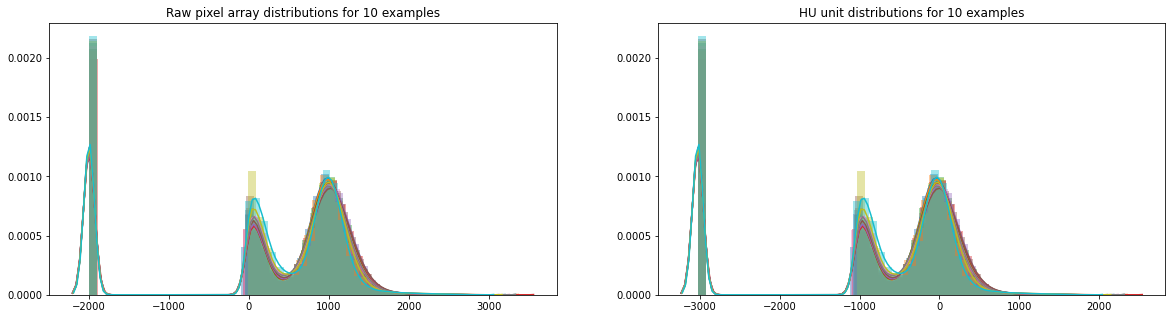

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
for n in range(10):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

We can see that there are some raw values at -2000. They correspond to images with a circular boundary within the image. The "outside" of this circle value is often set to -2000 (or in other competitions I found also -3000) by default.

In [10]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [11]:
hu_scans = transform_to_hu(scans)

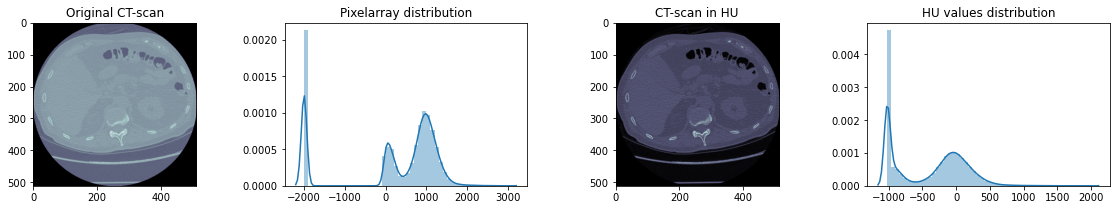

In [12]:
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax[0].set_title("Original CT-scan")
ax[0].imshow(scans[0].pixel_array, cmap="bone")
ax[1].set_title("Pixelarray distribution");
sns.distplot(scans[0].pixel_array.flatten(), ax=ax[1]);

ax[2].set_title("CT-scan in HU")
ax[2].imshow(hu_scans[0], cmap="bone")
ax[3].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[3]);

for m in [0,2]:
    ax[m].grid(False)

Ok great. The scan of our example patient had a circular boundary and now all raw values per slice are scaled to H-units.

## The voxel size <a class="anchor" id="voxel"></a>

The voxel stands for the 3D-pixel that is given in a CT-scan. As far as I know it is spanned by the 2d-plane of the pixelspacing attribute in x- and y-direction and the slice thickness in z-direction.

### Pixelspacing

* The pixelspacing attribute you can find in the dicom files is an important one. It tells us how much physical distance is covered by one pixel. You can see that there are only 2 values that describe the x- and y-direction in the plane of a transversal slice. 
* For one patient this pixelspacing is usually the same for all slices.
* But between patients the pixelspacing can differ due to personal or institutional preferences of doctors and the clinic and it also depends on the scanner type. Consequently if you compare two images in the size of the lungs it does not automatically mean that the bigger one is really larger in the physical size of the organ!

Let's explore the distributions of the patients pixelspacing widths and heights of this competition:

In [13]:
pixelspacing_w = []
pixelspacing_h = []
slice_thicknesses = []
patient_id = []
patient_pth = []

for patient in train.Patient.values:
    patient_id.append(patient)
    example_dcm = listdir(basepath + "train/" + patient + "/")[0]
    patient_pth.append(basepath + "train/" + patient)
    dataset = pydicom.dcmread(basepath + "train/" + patient + "/" + example_dcm)
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    pixelspacing_w.append(spacing[0])
    pixelspacing_h.append(spacing[1])

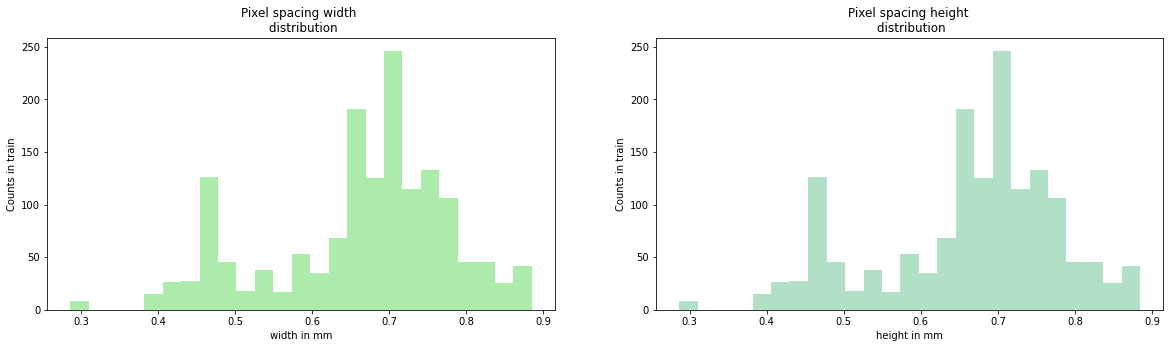

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_w, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing width \n distribution")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("width in mm")
sns.distplot(pixelspacing_h, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing height \n distribution");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("height in mm");

We can see that the values really vary a lot from patient to patient! As they are given in mm and ct-scans usually cover 512 row and column values, we can compute the minimum and maximum distance that is covered by the images:

In [15]:
0.03*512

15.36

Roughly 15 cm is the minimum distance.

In [16]:
0.09*512

46.08

And roughly 46 cm is the largest one.

When finishing this part, I would really like to see these extreme cases as 3D-reconstructions!

### Slice thickness

The slice thickness tells us how much distance is covered in Z-direction by one slice. Let's plot the distribution of it as well: 

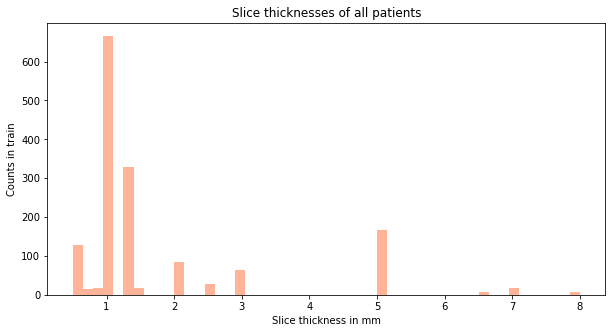

In [17]:
plt.figure(figsize=(10,5))
sns.distplot(slice_thicknesses, color="orangered", kde=False)
plt.title("Slice thicknesses of all patients");
plt.xlabel("Slice thickness in mm")
plt.ylabel("Counts in train");

Very thin slices allow more details to be shown. On the other hand thick slices contain less noise but are more prone to artifacts. Hmm... I'm very excited to see some examples in 3D here as well. 

If you like to discover more dicom attributes, I can recommend this [source](https://dicom.innolitics.com/ciods/ct-image/image-plane/00280030). 

## 3D-reconstruction of CT-scans <a class="anchor" id="reconstruction"></a>

As I like to compare the pixelspacing and the slice thickness attribute, we need to find the patient with smallest and largest cases of these attributes:

In [18]:
#my_attribute = slice_thicknesses
my_attribute = pixelspacing_w
#my_attribute = pixelspacing_h

In [19]:
min_idx = np.argsort(my_attribute)[0]
max_idx = np.argsort(my_attribute)[-1]

patient_min = patient_pth[min_idx]
patient_max = patient_pth[max_idx]

min_scans = load_scans(patient_min)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(patient_max)
max_hu_scans = transform_to_hu(max_scans)

In [20]:
def plot_3d(image, threshold=700, color="navy"):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

Let's take a look at the bones of the patients we like to compare:

In [21]:
#plot_3d(min_hu_scans)

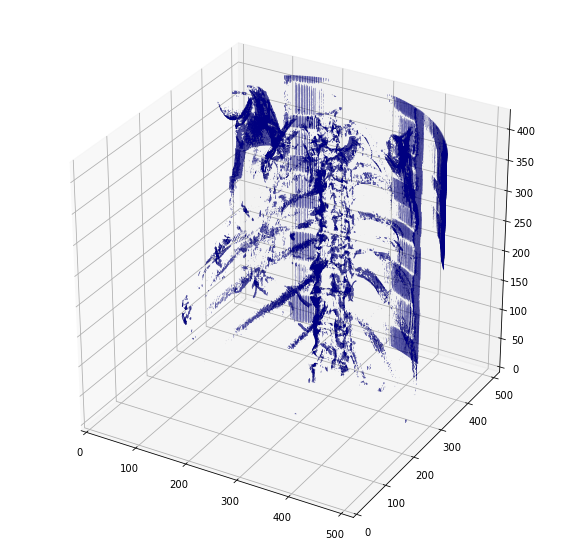

In [22]:
plot_3d(max_hu_scans)

## Resampling the voxel size

**CAUTION** Work in progress and something weird is going on here!

In [23]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [24]:
pix_resampled, spacing = resample(max_hu_scans, scans, [1,1,1])
print("Shape before resampling\t", hu_scans.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (30, 512, 512)
Shape after resampling	 (529, 334, 334)


## Tissue segmentation <a class="anchor" id="segmentation"></a>

In [25]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_tissue(image, threshold=-300, fill_lung_structures=True):
    
    labelled_image = np.array(image > threshold, dtype=np.int8)+1
    labels = measure.label(labelled_image)
    
    
    #Fill the air around the person
    background_label = labels[0,0]
    labelled_image[background_label == labels] = 2
    
    labelled_image -= 1 #Make the image actual binary
    labelled_image = 1-labelled_image # Invert it, lungs are now 1
    
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(labelled_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                labelled_image[i][labeling != l_max] = 1
    
    # Remove other air pockets insided body
    labels = measure.label(labelled_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        labelled_image[labels != l_max] = 0
    
    return labelled_image

In [26]:
segmented_lungs = segment_tissue(max_hu_scans, fill_lung_structures=False)
segmented_lungs_fill = segment_tissue(max_hu_scans, fill_lung_structures=True)

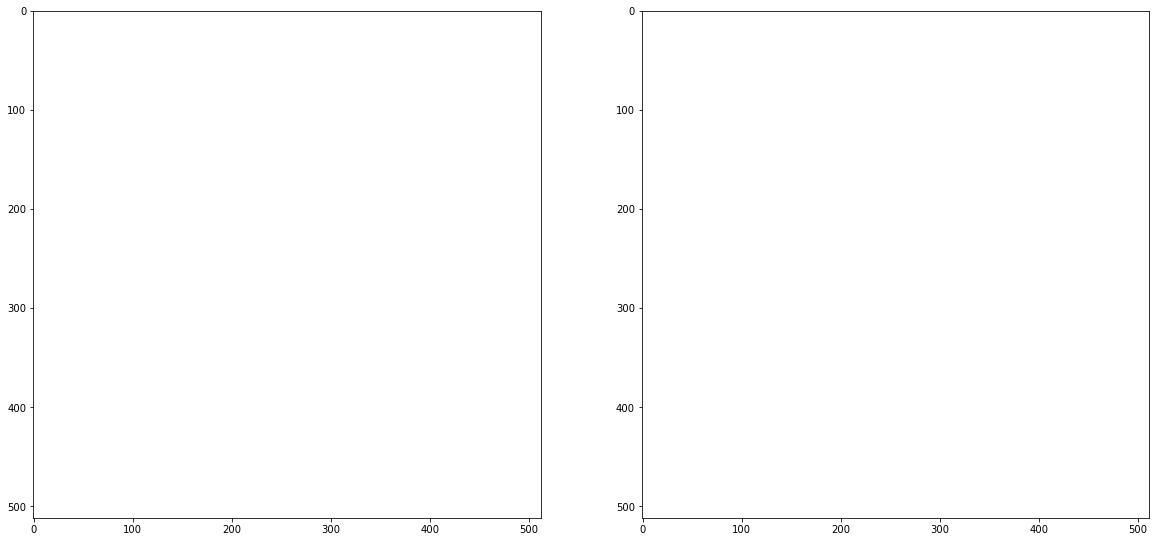

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(segmented_lungs[20], cmap="bone_r")
ax[1].imshow(segmented_lungs_fill[20], cmap="bone_r")
for n in range(2):
    ax[n].grid(False)

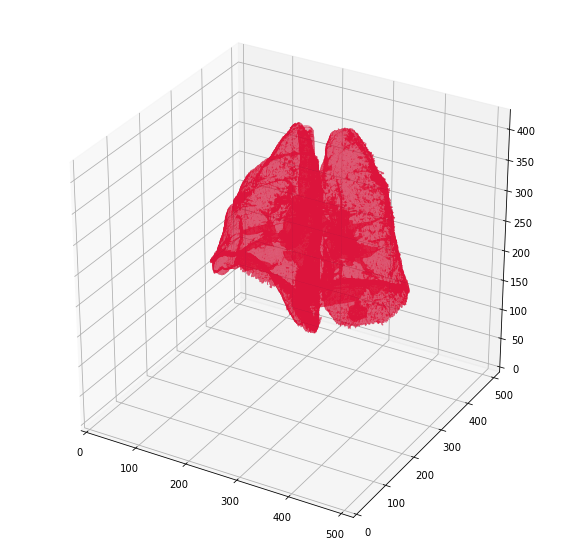

In [28]:
plot_3d(segmented_lungs_fill, threshold=0, color="crimson")

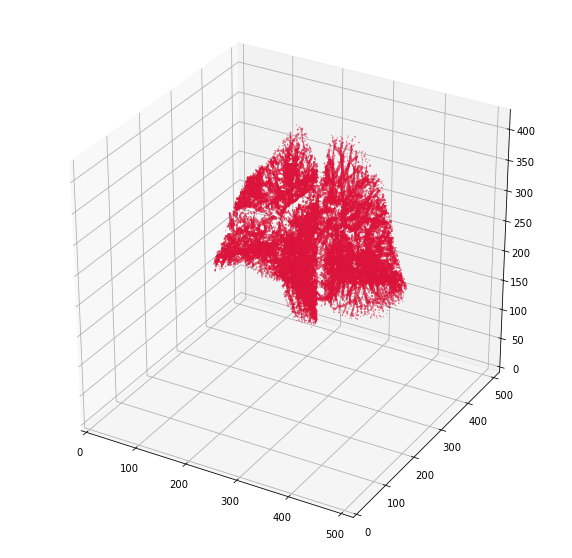

In [29]:
plot_3d(segmented_lungs_fill-segmented_lungs, threshold=0, color="crimson")

At the moment I would say that we can't just take the solution as given in the tutorial but have to adapt to our dataset. I will start reading about resampling the voxel size and a bit more about lung segmentation before continuing and creating the dataset.  

## Normalization <a class="anchor" id="normalization"></a>

## Zero centering <a class="anchor" id="zero_centering"></a>

# Generating a dataset for preprocessed files <a class="anchor" id="datagenerator"></a>